In [126]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, Embedding
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import datetime
from tqdm import tqdm
print(f'Current Step #01 [now = {datetime.now()}')


Current Step #01 [now = 2025-06-27 17:55:27.882044


In [128]:
results = {}

In [127]:
def load_metrics(random_state, version, db_file_path):
    query = f'select rounds, matched_cnts from rndforest where random_state={random_state} and version=\\"{version}\\"'
    metrics = !echo {query} | sqlite3 {db_file_path}
    # print(metrics)
    if len(metrics) > 0:
        metrics = metrics[0].split('|')
        return metrics[0], metrics[1] 
    return [], []


def load_data(version="T_01_10", db_file_path='../db/metrics.db', random_state=113789):
    rounds_str, matched_cnts_str = load_metrics(random_state=random_state, db_file_path=db_file_path, version=version)
    rounds = []
    matched_cnts = []
    if len(rounds_str) > 0 and len(matched_cnts_str) > 0:
        for i in rounds_str.split(','):
            rounds.append(int(i))
        for i in matched_cnts_str.split(','):
            matched_cnts.append(int(i))
        rounds.reverse()
        matched_cnts.reverse()
        df = pd.DataFrame(zip(rounds, matched_cnts), columns=['rounds', 'matched_cnts'])
        return df
    return None


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


print(f'Current Step #01 [now = {datetime.now()}')

Current Step #01 [now = 2025-06-27 17:55:29.557905


In [4]:
time_steps = 10
data_dim = 1
num_samples = 100
X = np.random.rand(num_samples, time_steps, data_dim)
print(len(X))

100


In [96]:
from enum import Enum

class ScalerType(Enum):
    PRIVATE=0,
    STANDARD=1,
    MIN_MAX=2


def restore_private(data, min, mux, divider):
    new_data = []
    for i in data:
        cleaned = i[0] - min
        if cleaned < 0.0:
            cleaned = 0.
        new_data.append(cleaned)
    restored = np.array([[(round(i, 6)*mux)] for i in new_data])
    return restored    

"""
            new_data = []
            for i in data[0]:
                cleaned = i[0] * self._divider - self.p_min
                if cleaned < 0:
                    cleaned = 0.
                new_data.append(cleaned)
            restored = np.array([[(round((cleaned*self.p_mux),3)/10.0)] for i in new_data])

"""

class PrivateScaler:
    def __init__(self, divider=6.0):
        """" __init___ """
        self._divider = divider
        self.p_max = 1
        self.p_min = -1
        self.p_mux = 1

    def adjust_parameter1(self, data, add_mux):
        if len(data) > 1:
            if self.p_min == -1:
                self.p_max = data.max() * self._divider
                self.p_min = data.min() * self._divider
                max_diff_val = self.p_max - self.p_min
                print('min, max, diff', self.p_min, self.p_max, max_diff_val)
                while (max_diff_val * self.p_mux) < 1.:
                    self.p_mux *= 10
                self.p_mux += add_mux
        else:
            pass

    def adjust_parameter(self, data, add_mux):
        if len(data) > 1:
            if self.p_min == -1:
                self.p_max = data.max()
                self.p_min = data.min()
                max_diff_val = self.p_max - self.p_min
                print('min, max, diff', self.p_min, self.p_max, max_diff_val)
                while (max_diff_val * self.p_mux) < 0.1:
                    self.p_mux *= 10
                self.p_mux += add_mux
        else:
            pass

    def fit_transform(self, data):
        """ fit_transform """
        self.p_max = data.max() + 1
        self._divider = self.p_max
        scaled_data = np.array([[round(float(i[0])/self._divider, 9)] for i in data])
        return scaled_data

    def inverse_transform1(self, data, add_mux=0.):
        """ inverse_transform """
        import math
        if data[1]:
            self.adjust_parameter(data[0], add_mux)
            # restored = np.array([[((i[0] * self._divider - self.p_min) * self.p_mux)] for i in data[0]])
            restored = np.array([[math.pow(round((i[0] * self._divider - self.p_min),3),2)] for i in data[0]])
        else:
            restored = np.array([[i[0] * self._divider] for i in data[0]])
        return restored

    def inverse_transform(self, data, add_mux=0.):
        """ inverse_transform """
        import math
        if data[1]:
            self.adjust_parameter(data[0], add_mux)
            # restored = np.array([[((i[0] * self._divider - self.p_min) * self.p_mux)] for i in data[0]])
            restored = restore_private(data[0], self.p_min, self.p_mux, self._divider)
        else:
            restored = np.array([[i[0] * self._divider] for i in data[0]])
        return restored


scaler_cls = {
    ScalerType.PRIVATE: PrivateScaler,
    ScalerType.STANDARD: StandardScaler,
    ScalerType.MIN_MAX: MinMaxScaler # feature_range=(0,1)
    }


class DataScaling():
    def __init__(self, scaler_type: ScalerType, *args: list):
        self._scaler_type = scaler_type
        self._scaler_cls = scaler_cls[scaler_type](*args)

    def fit_transform(self, data):
        return self._scaler_cls.fit_transform(data)

    def inverse_transform(self, datas: list):
        inversed_data = []
        min = -1
        max = 1
        mux = -1
        div = 1
        if self._scaler_type == ScalerType.PRIVATE:
            for data in datas:
                if data[1] == True:
                    inversed = self._scaler_cls.inverse_transform((data[0].reshape(-1, 1), data[2]))
                else:
                    inversed = self._scaler_cls.inverse_transform((data[0], data[2]))
                inversed_data.append(inversed)
            min = self._scaler_cls.p_min
            max = self._scaler_cls.p_max
            mux = self._scaler_cls.p_mux
            div = self._scaler_cls._divider
        else:
            cnt = 1
            for data in datas:
                cnt += 1
                if data[1] == True:
                    inversed = self._scaler_cls.inverse_transform(data[0].reshape(-1, 1))
                else:
                    inversed = self._scaler_cls.inverse_transform(data[0])
                inversed_data.append(inversed)
            min = 0
        return inversed_data, min, max, mux, div


### 최종 결과 입니다.
def analyze_v1(random_state,
               version,
               db_file_path,
               scaler_type=ScalerType.PRIVATE,
               layers=[(False)],
               activation='sigmoid',
               units=50,
               draw_graph=True,
               sequence_length=10,
               optimizer="adam",
               loss='mean_squared_error',
               add_mux=0,
               verbose=0):
    """
     - loss = [binary_crossentropy, mean_squared_error, ]
     - optimizer = [adam, ]

    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    # 1. Prepare the Data
    # Create sample time series data
    df = load_data(version=version, db_file_path=db_file_path, random_state=random_state)
    if df is None:
        return -1, '', random_state

    if verbose > 0:
        print('df', df)
    if verbose > 0:
        print(f'Current Step #02 [now = {datetime.now()}]')

    data = df['matched_cnts'].values.reshape(-1, 1)

    # Normalize the data
    scaler = DataScaling(scaler_type)
    scaled_data = scaler.fit_transform(data)
    if verbose > 0:
        print(f'Current Step #04 [now = {datetime.now()}]')

    # Define sequence length (timesteps)

    # Create sequences for training
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length, 0])
        y.append(scaled_data[i + sequence_length, 0])
    X, y = np.array(X), np.array(y)
    # print('X=', X)
    # print('y=', y)
    if verbose > 0:
        print(f'Current Step #06 [now = {datetime.now()}]')

    # Reshape X for LSTM input (samples, timesteps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    if verbose > 0:
        print(f'Current Step #08 [now = {datetime.now()}]')

    # Split data into training and testing sets
    # train_size = int(len(X) * 0.8)
    train_size = int(len(X) * 0.8)

    X_train, X_test, X_last = X[:train_size], X[train_size:], np.array([[y[-1:]]])
    y_train, y_test = y[:train_size], y[train_size:]
    if verbose > 0:
        print(f'Current Step #10 [now = {datetime.now()}]')

    # print('len (train) = ', len(X_train), len(X_train[0]))
    # print('len (test ) = ', len(X_test), len(X_test[0]))
    # return [], [], [], []
    
    tf.random.set_seed(random_state)

    # 2. Build the LSTM Model
    model = Sequential()
    input_shape = (X_train.shape[1], 1)
    embedding_dim = 1
    max_len = sequence_length
    vocab_size = len(data)
    # print('input_shape', input_shape)
    
    # if is_bidirectional = :
    # else:
    model.add(Input(shape=input_shape))
    for i in range(len(layers)):
        print(f'add layter [{i}]')
        if i < (len(layers) - 1):
            return_sequences=True
        else:
            return_sequences=False
        print(f'Bidirectional = {layers[i][0]}')
        if layers[i][0]==True:
            model.add(Bidirectional(LSTM(units=units,
                                         activation=activation,
                                         return_sequences=return_sequences),))
        else:
            model.add(LSTM(units=units,
                           activation=activation,
                           return_sequences=return_sequences))
                                    # input_shape=input_shape))

    # model.add(LSTM(units=units, activation=activation))
    model.add(Dense(units=1)) # Output layer for predicting a single value
    if verbose > 0:
        print(f'Current Step #12 [now = {datetime.now()}]')

    # 3. Compile and Train the Model
    model.compile(optimizer=optimizer, loss=loss)
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0) # verbose=0 for silent training

    if verbose > 0:
        print(f'Current Step #14 [now = {datetime.now()}]')

    # 4. Make Predictions
    train_predict = model.predict(X_train, verbose=verbose)
    test_predict = model.predict(X_test, verbose=verbose)
    last_predict_0 = model.predict(X_last, verbose=verbose)
    if verbose > 0:
        print(f'Current Step #16 [now = {datetime.now()}]')

    # Inverse transform predictions to original scale
    scaled_data1 = scaled_data
    # last_predict_0 = last_predict_0.reshape(-1, 1)
    train_predict_len = len(train_predict)
    test_predict_len = len(test_predict)
    last_predict_len = len(last_predict_0)
    print('lens  = ', train_predict_len, test_predict_len, last_predict_len)
    print('types = ', type(train_predict), type(test_predict), type(last_predict_0))

    # t_predict = np.concatenate((train_predict, test_predict, last_predict_0), axis=0)
    t_predict = np.concatenate((train_predict, test_predict), axis=0)
    wanted_datas = [(t_predict, False, True),
                    (last_predict_0, True, False),
                    (y_train, True, False),
                    (y_test, True, False),
                    (scaled_data, False, False)]
    inversed_datas, scaler_min, scaler_max, scaler_mux, scaler_div = scaler.inverse_transform(wanted_datas)
    t_predict = inversed_datas[0]
    last_predict = inversed_datas[1]
    y_train_original = inversed_datas[2]
    y_test_original = inversed_datas[3]
    scaled_data = inversed_datas[4]
    train_predict = t_predict[:train_predict_len]
    test_predict = t_predict[train_predict_len:train_predict_len+test_predict_len]
    print("scaler_min, scaler_max, scaler_mux, scaler_div", scaler_min, scaler_max, scaler_mux, scaler_div)
    # last_predict = t_predict[train_predict_len+test_predict_len:train_predict_len+test_predict_len+last_predict_len]
    if verbose > 0:
        print(f'Current Step #18 [now = {datetime.now()}]')

    # 5. Evaluate the Model (Optional, but recommended)
    from sklearn.metrics import mean_squared_error
    train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
    test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))

    if verbose > 0:
        print(f'Current Step #20 [now = {datetime.now()}]')
        print(f"Train RMSE: {train_rmse}")
        print(f"Test RMSE: {test_rmse}")
        print(f'random_state = {random_state}')
        print(f'last_prediction = {last_predict}')
        print(f'data_max_val = {scaled_data.max()}')
    # You can also visualize the results
    test_last_predict = test_predict[-1:]
    if draw_graph:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        plt.plot(scaled_data1, label='Original Data')
        plt.plot(np.arange(sequence_length,
                           sequence_length + len(train_predict)),
                 train_predict,
                 label='Train Predictions')
        plt.plot(np.arange(sequence_length + len(train_predict),
                           sequence_length + len(train_predict) + len(test_predict)),
                 test_predict,
                 label='Test Predictions')
        # plt.plot(np.arange(sequence_length + len(train_predict) + len(test_predict),
        #          sequence_length + len(train_predict) + len(test_predict) + len(last_predict)),
        #          last_predict,
        #          label='Last Predictions')
        plt.xlabel(f'{random_state}\'s Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    restored_last_predict = restore_private(last_predict_0.reshape(-1, 1), scaler_min, scaler_mux, scaler_div)
    return {
        "scaled_data_max": scaled_data.max(),
        "scaled_data_min": scaled_data.min(),
        "last_predict": last_predict,
        "last_predict_or": last_predict_0,
        "restored_last_predict": restored_last_predict,
        "test_last_predict": test_last_predict,
        "X_last": X_last,
        "random_state": random_state,
        "scaler_min": scaler_min,
        "scaler_max": scaler_max,
        "scaler_mux": scaler_mux,
        "scaler_div": scaler_div
    }

print(f'Current work : {datetime.now()}')

Current work : 2025-06-27 15:45:50.090193


In [97]:
version = "T_01_13"
t_version = "T_01_93"
predict_result = []
print(f'Current work : {datetime.now()}')

Current work : 2025-06-27 15:45:50.506532


add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  285 72 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.18930134 0.25371057 0.064409226
scaler_min, scaler_max, scaler_mux, scaler_div 0.18930134 0.25371057 10.0 4


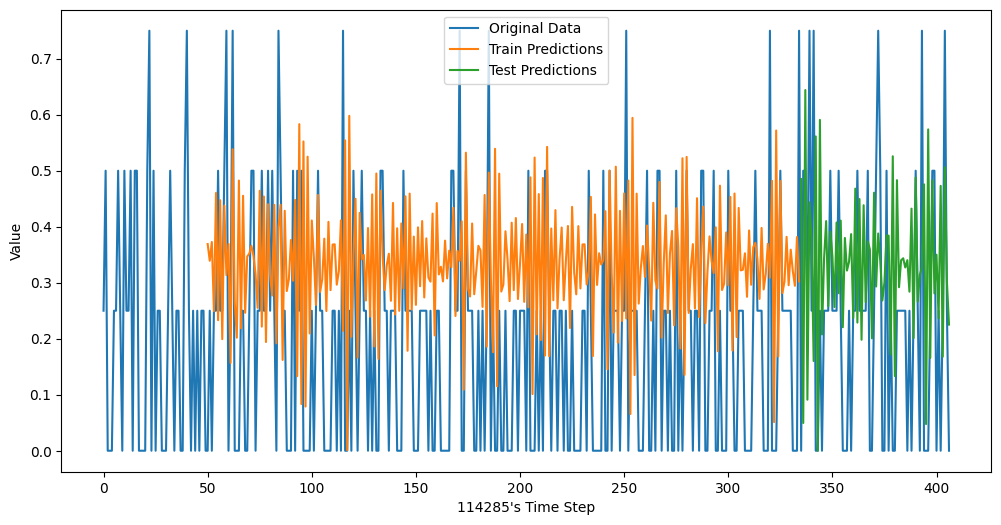

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.16264211]]), 'last_predict_or': array([[0.04066053]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.2252]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 114285, 'scaler_min': np.float32(0.18930134), 'scaler_max': np.float32(0.25371057), 'scaler_mux': 10.0, 'scaler_div': np.int64(4)} now 2025-06-27 15:48:37.667683


In [98]:
### Good Condition #1
t_version = "T_01_94"
db_file_path = '../db/metrics.db'
random_state = 114285
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 45
sequence_length = 50

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
# predict_result.append((results["scaled_data_max"],
#                        results["last_predict"],
#                        results["test_last_predict"],
#                        results["random_state"],
#                        units,
#                        sequence_length,
#                        activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  285 72 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.20947677 0.20991501 0.00043824315
scaler_min, scaler_max, scaler_mux, scaler_div 0.20947677 0.20991501 1000.0 4


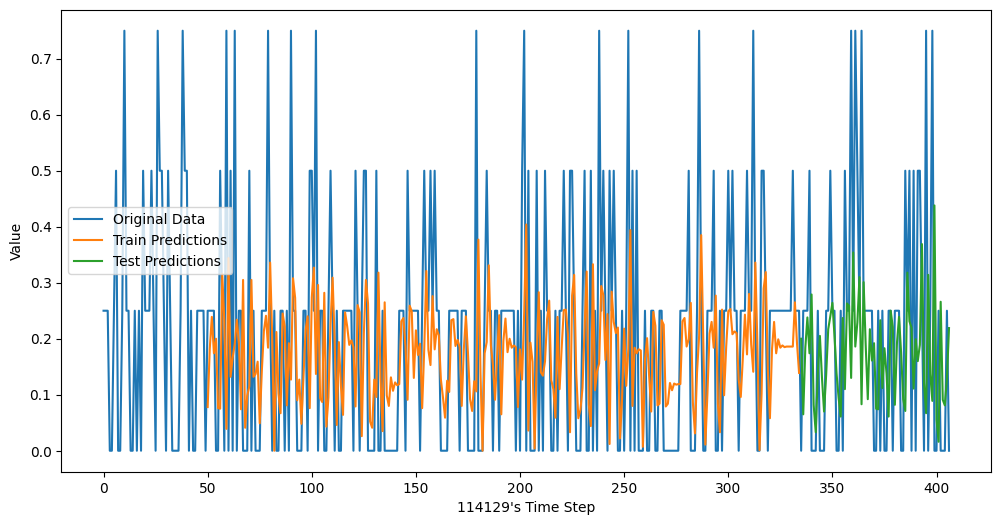

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.86519396]]), 'last_predict_or': array([[0.21629849]], dtype=float32), 'restored_last_predict': array([[6.822]], dtype=float32), 'test_last_predict': array([[0.219]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 114129, 'scaler_min': np.float32(0.20947677), 'scaler_max': np.float32(0.20991501), 'scaler_mux': 1000.0, 'scaler_div': np.int64(4)} now 2025-06-27 15:55:25.241096


In [99]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114129
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 50

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  285 72 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.23011781 0.23114643 0.0010286123
scaler_min, scaler_max, scaler_mux, scaler_div 0.23011781 0.23114643 100.0 5


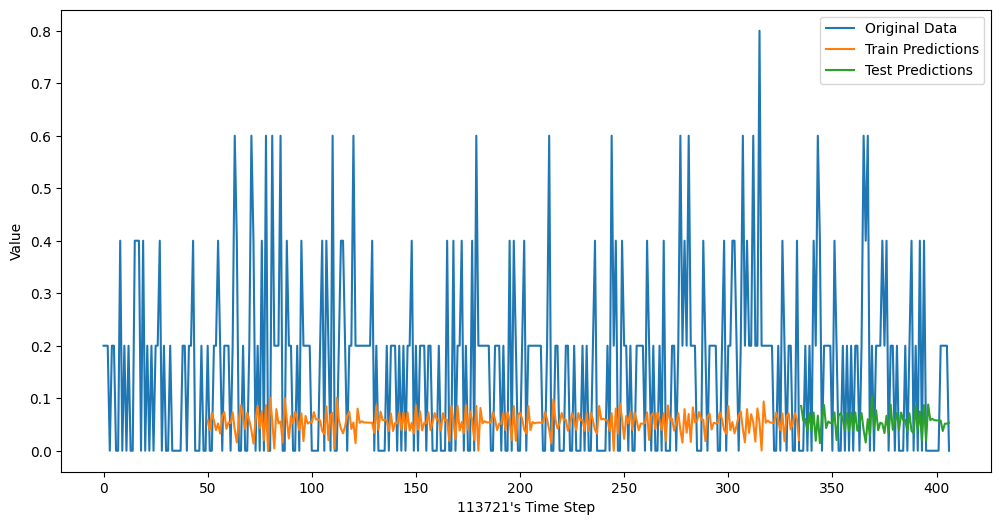

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.24995122]]), 'last_predict_or': array([[0.04999024]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.0532]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 113721, 'scaler_min': np.float32(0.23011781), 'scaler_max': np.float32(0.23114643), 'scaler_mux': 100.0, 'scaler_div': np.int64(5)} now 2025-06-27 16:02:48.134085


In [100]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 113721
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 50

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  285 72 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.16345437 0.1951546 0.03170024
scaler_min, scaler_max, scaler_mux, scaler_div 0.16345437 0.1951546 10.0 5


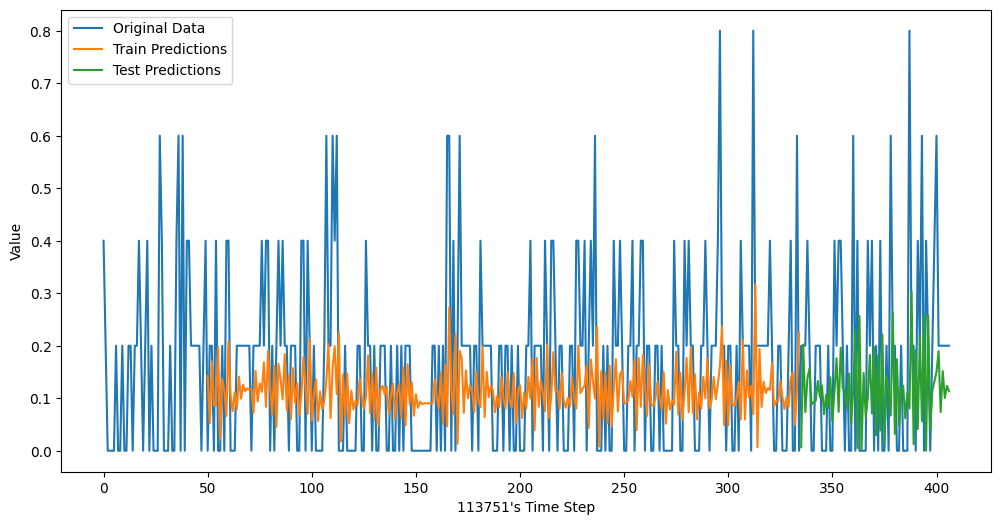

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.74062996]]), 'last_predict_or': array([[0.14812599]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.11343001]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 113751, 'scaler_min': np.float32(0.16345437), 'scaler_max': np.float32(0.1951546), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 16:07:45.475442


In [101]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 113751
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 50

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  285 72 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.17195413 0.24568792 0.07373379
scaler_min, scaler_max, scaler_mux, scaler_div 0.17195413 0.24568792 10.0 4


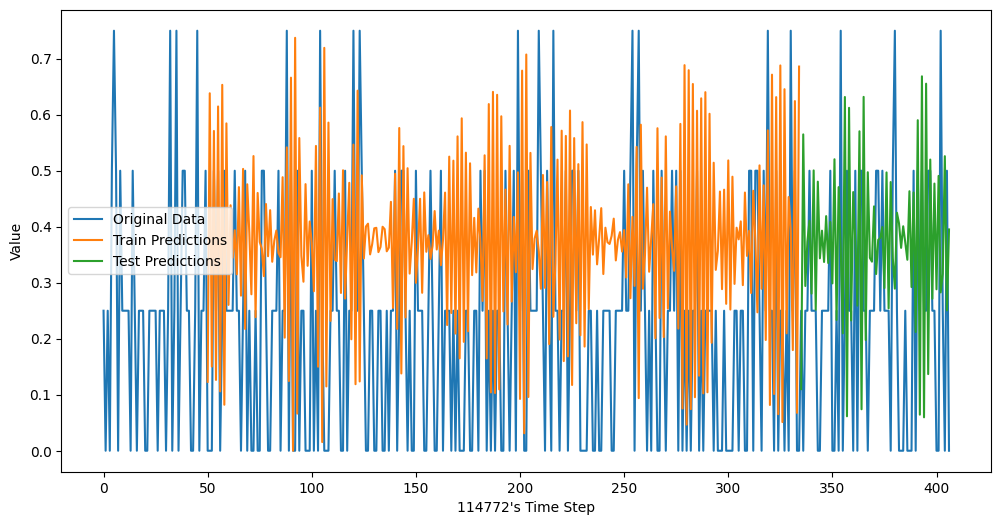

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.5040468]]), 'last_predict_or': array([[0.3760117]], dtype=float32), 'restored_last_predict': array([[2.04058]], dtype=float32), 'test_last_predict': array([[0.39514002]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 114772, 'scaler_min': np.float32(0.17195413), 'scaler_max': np.float32(0.24568792), 'scaler_mux': 10.0, 'scaler_div': np.int64(4)} now 2025-06-27 16:11:27.243387


In [102]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114772
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 50

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  285 72 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.14734565 0.17361243 0.026266783
scaler_min, scaler_max, scaler_mux, scaler_div 0.14734565 0.17361243 10.0 5


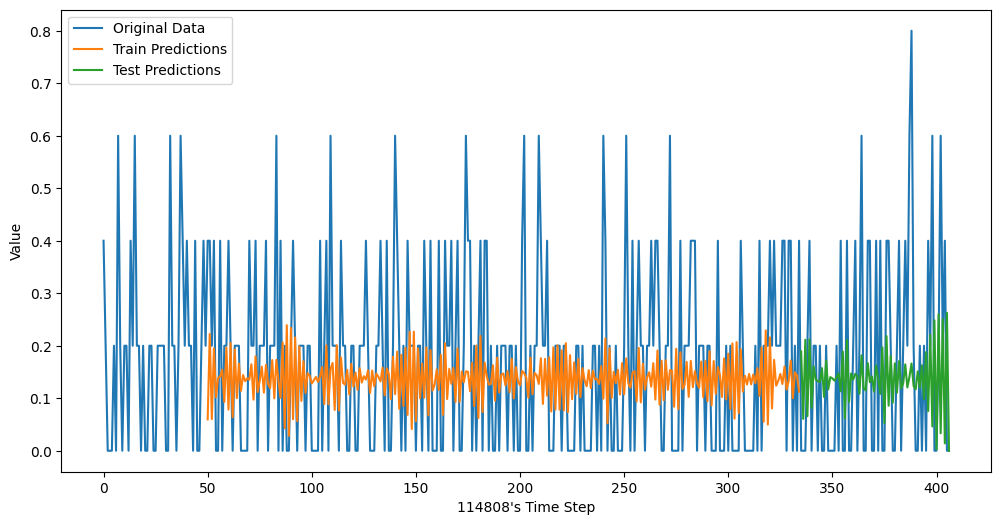

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.0669401]]), 'last_predict_or': array([[0.01338802]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 114808, 'scaler_min': np.float32(0.14734565), 'scaler_max': np.float32(0.17361243), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 16:15:21.487782


In [103]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114808
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.16904029 0.27210435 0.10306406
scaler_min, scaler_max, scaler_mux, scaler_div 0.16904029 0.27210435 1.0 5


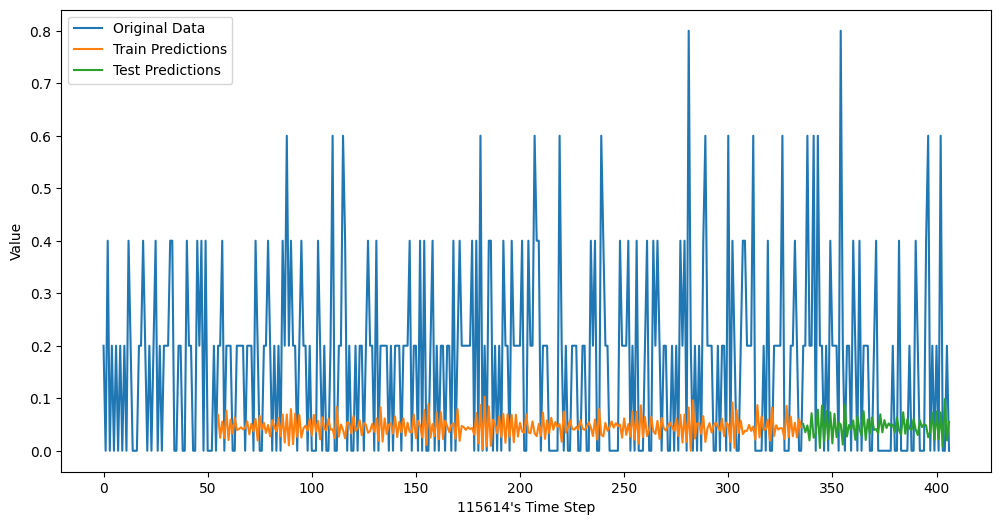

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.63492253]]), 'last_predict_or': array([[0.1269845]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.054714]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 115614, 'scaler_min': np.float32(0.16904029), 'scaler_max': np.float32(0.27210435), 'scaler_mux': 1.0, 'scaler_div': np.int64(5)} now 2025-06-27 16:19:04.071228


In [104]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 115614
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.23761384 0.23769821 8.4370375e-05
scaler_min, scaler_max, scaler_mux, scaler_div 0.23761384 0.23769821 10000.0 4


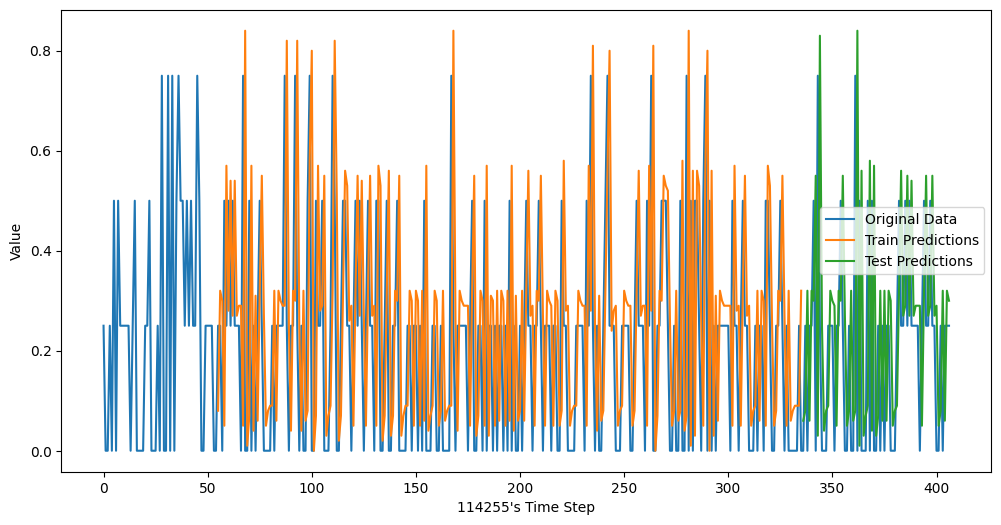

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.03140092]]), 'last_predict_or': array([[0.25785023]], dtype=float32), 'restored_last_predict': array([[202.36]], dtype=float32), 'test_last_predict': array([[0.29999998]], dtype=float32), 'X_last': array([[[0.25]]]), 'random_state': 114255, 'scaler_min': np.float32(0.23761384), 'scaler_max': np.float32(0.23769821), 'scaler_mux': 10000.0, 'scaler_div': np.int64(4)} now 2025-06-27 16:23:05.602930


In [105]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114255
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.09458295 0.2525435 0.15796056
scaler_min, scaler_max, scaler_mux, scaler_div 0.09458295 0.2525435 1.0 5


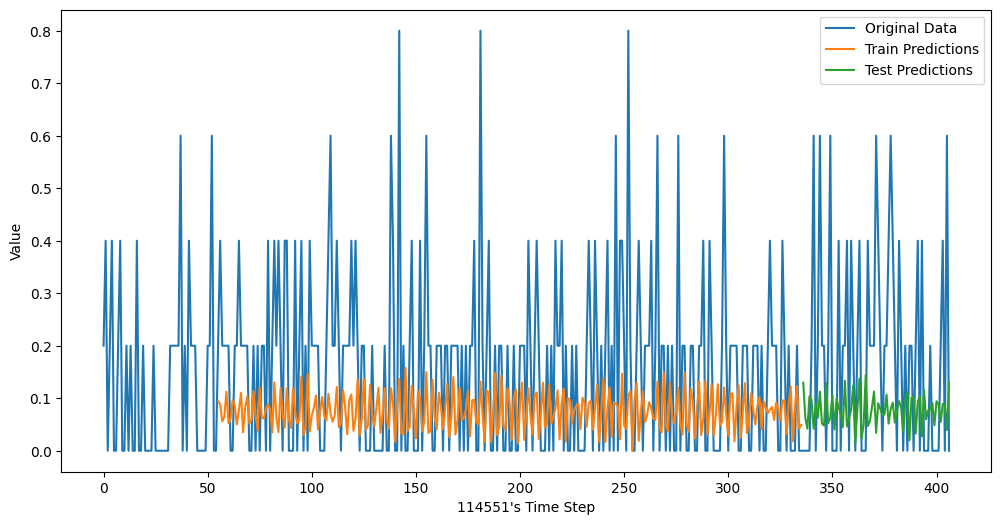

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.86756209]]), 'last_predict_or': array([[0.37351242]], dtype=float32), 'restored_last_predict': array([[0.278929]], dtype=float32), 'test_last_predict': array([[0.129486]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 114551, 'scaler_min': np.float32(0.09458295), 'scaler_max': np.float32(0.2525435), 'scaler_mux': 1.0, 'scaler_div': np.int64(5)} now 2025-06-27 16:27:12.223365


In [106]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114551
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.18601097 0.18621312 0.00020214915
scaler_min, scaler_max, scaler_mux, scaler_div 0.18601097 0.18621312 1000.0 4


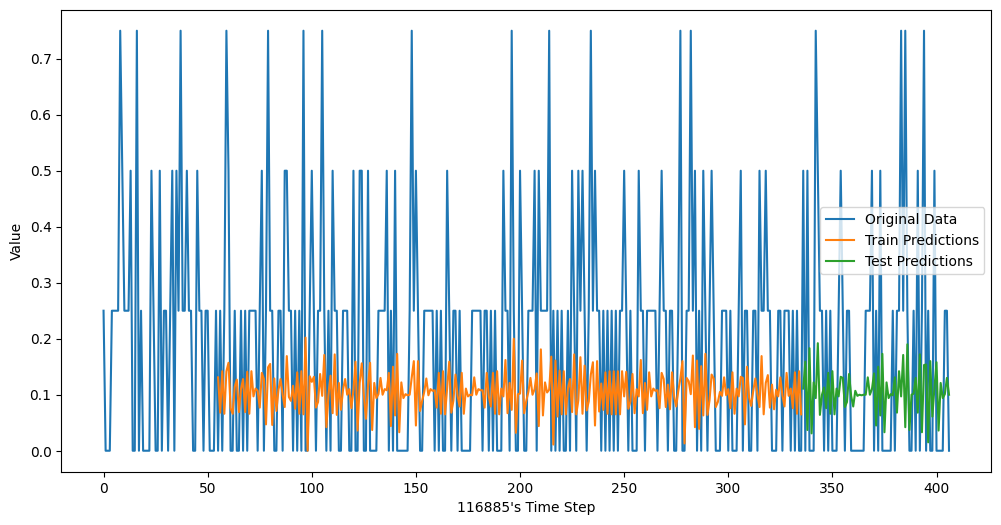

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.04902852]]), 'last_predict_or': array([[0.26225713]], dtype=float32), 'restored_last_predict': array([[76.246]], dtype=float32), 'test_last_predict': array([[0.09999999]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 116885, 'scaler_min': np.float32(0.18601097), 'scaler_max': np.float32(0.18621312), 'scaler_mux': 1000.0, 'scaler_div': np.int64(4)} now 2025-06-27 16:36:11.076509


In [107]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 116885
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 16:46:21.585080
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.12695272 0.14176756 0.014814839
scaler_min, scaler_max, scaler_mux, scaler_div 0.12695272 0.14176756 10.0 5


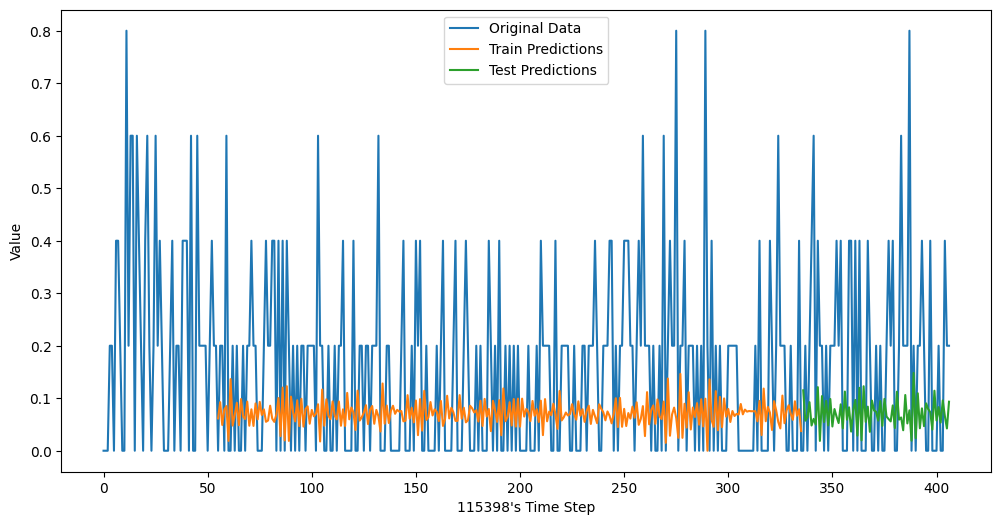

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.27678568]]), 'last_predict_or': array([[0.05535714]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.09335]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 115398, 'scaler_min': np.float32(0.12695272), 'scaler_max': np.float32(0.14176756), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 16:49:01.183434


In [109]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 115398
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 16:49:47.884078
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.15036944 0.17740753 0.027038097
scaler_min, scaler_max, scaler_mux, scaler_div 0.15036944 0.17740753 10.0 5


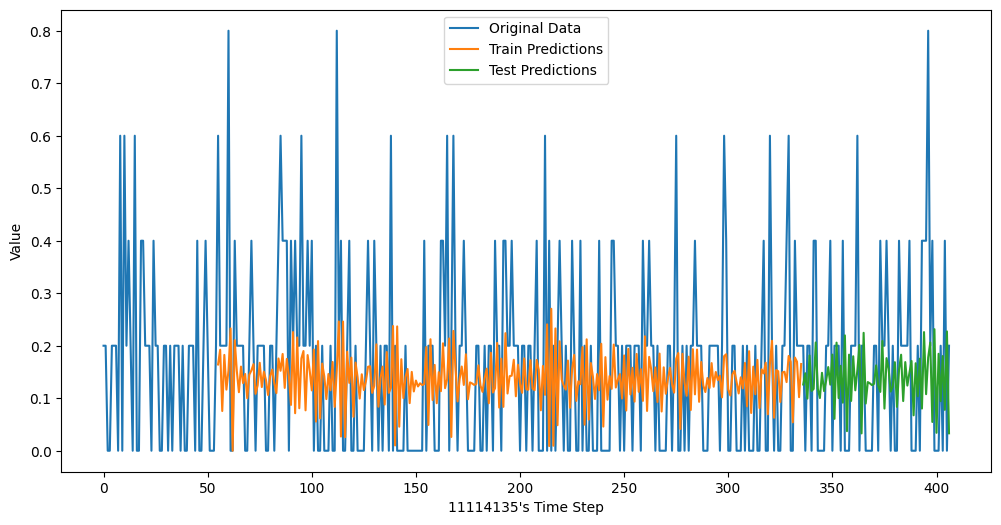

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[-0.82113653]]), 'last_predict_or': array([[-0.1642273]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.03319]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 11114135, 'scaler_min': np.float32(0.15036944), 'scaler_max': np.float32(0.17740753), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 16:52:23.794653


In [110]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 11114135
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 16:53:50.229458
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.15416247 0.1722718 0.018109336
scaler_min, scaler_max, scaler_mux, scaler_div 0.15416247 0.1722718 10.0 5


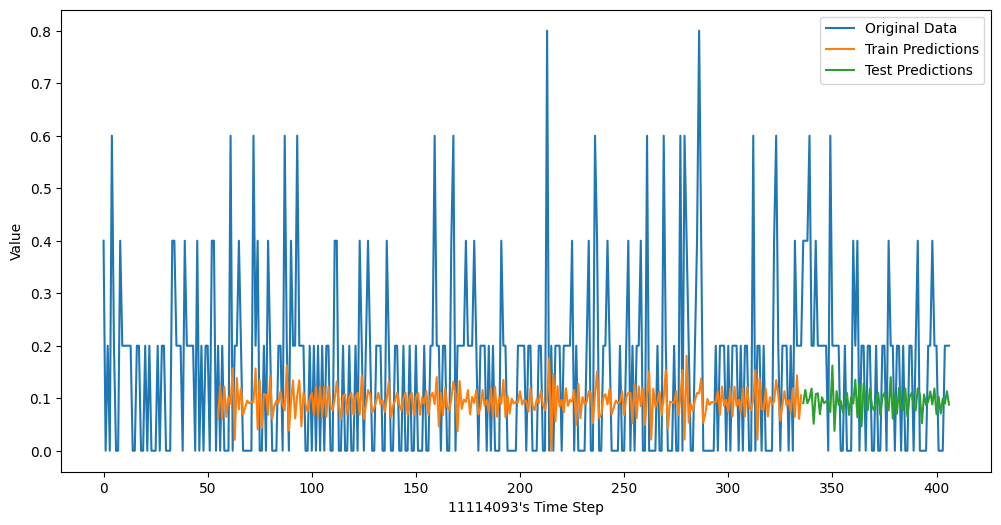

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.56670535]]), 'last_predict_or': array([[0.11334107]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.08798]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 11114093, 'scaler_min': np.float32(0.15416247), 'scaler_max': np.float32(0.1722718), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 16:56:28.695855


In [111]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 11114093
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 16:57:35.937723
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.12829131 0.16304944 0.034758136
scaler_min, scaler_max, scaler_mux, scaler_div 0.12829131 0.16304944 10.0 5


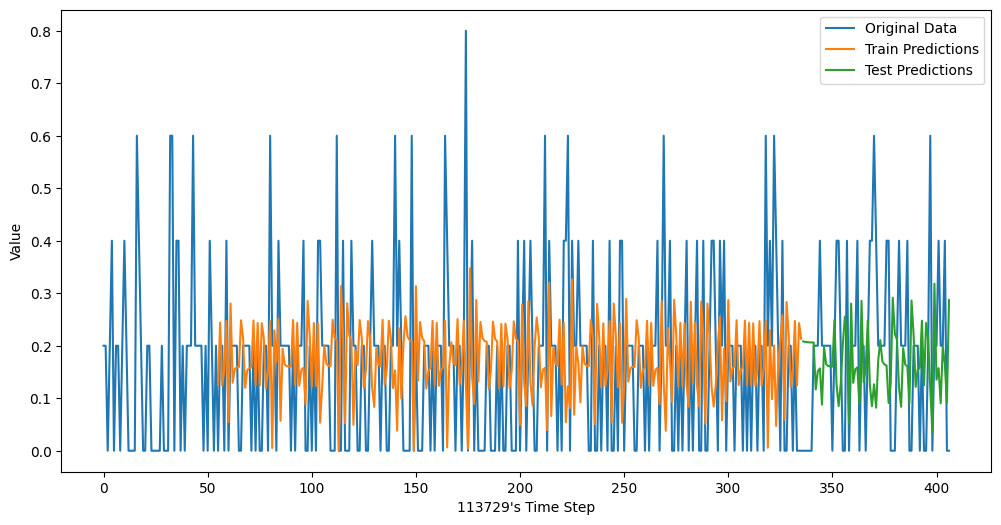

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.71355678]]), 'last_predict_or': array([[0.14271136]], dtype=float32), 'restored_last_predict': array([[0.1442]], dtype=float32), 'test_last_predict': array([[0.28675]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 113729, 'scaler_min': np.float32(0.12829131), 'scaler_max': np.float32(0.16304944), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 17:00:17.562616


In [112]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 113729
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:01:17.377165
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.20244165 0.20314904 0.0007073879
scaler_min, scaler_max, scaler_mux, scaler_div 0.20244165 0.20314904 1000.0 4


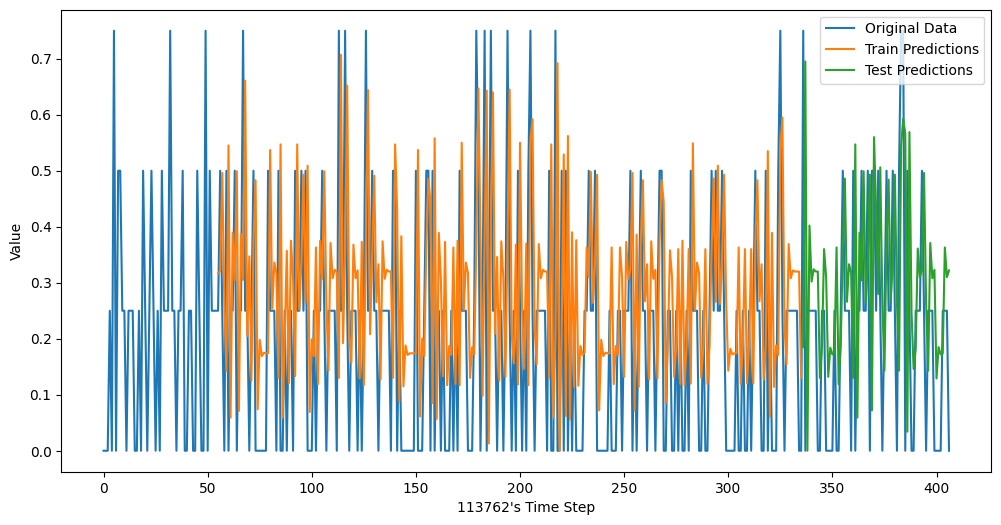

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.02573097]]), 'last_predict_or': array([[0.25643274]], dtype=float32), 'restored_last_predict': array([[53.991]], dtype=float32), 'test_last_predict': array([[0.322]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 113762, 'scaler_min': np.float32(0.20244165), 'scaler_max': np.float32(0.20314904), 'scaler_mux': 1000.0, 'scaler_div': np.int64(4)} now 2025-06-27 17:03:59.812158


In [113]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 113762
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:07:21.049208
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.22402306 0.23055007 0.0065270066
scaler_min, scaler_max, scaler_mux, scaler_div 0.22402306 0.23055007 100.0 4


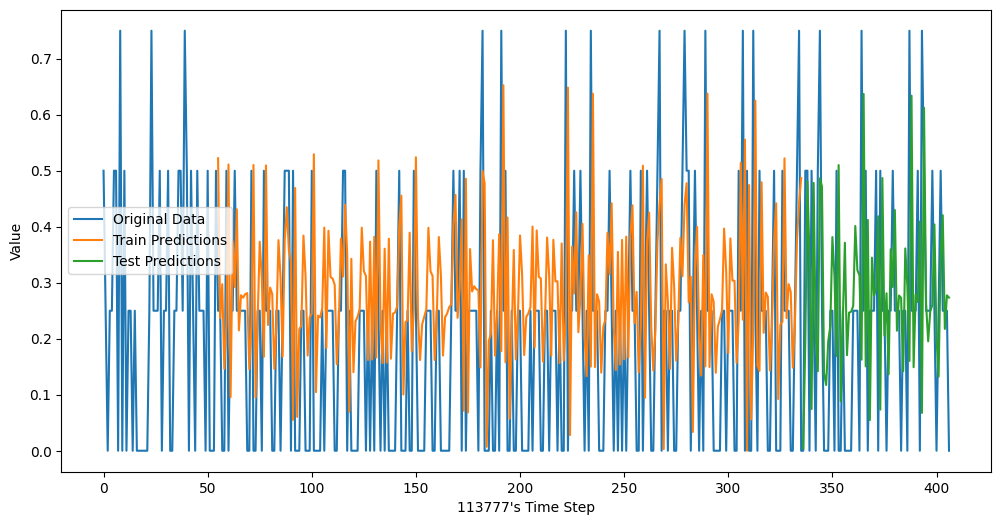

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.20310442]]), 'last_predict_or': array([[0.05077611]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.2734]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 113777, 'scaler_min': np.float32(0.22402306), 'scaler_max': np.float32(0.23055007), 'scaler_mux': 100.0, 'scaler_div': np.int64(4)} now 2025-06-27 17:09:59.569924


In [114]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 113777
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:11:27.374628
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.13896355 0.14036874 0.0014051944
scaler_min, scaler_max, scaler_mux, scaler_div 0.13896355 0.14036874 100.0 5


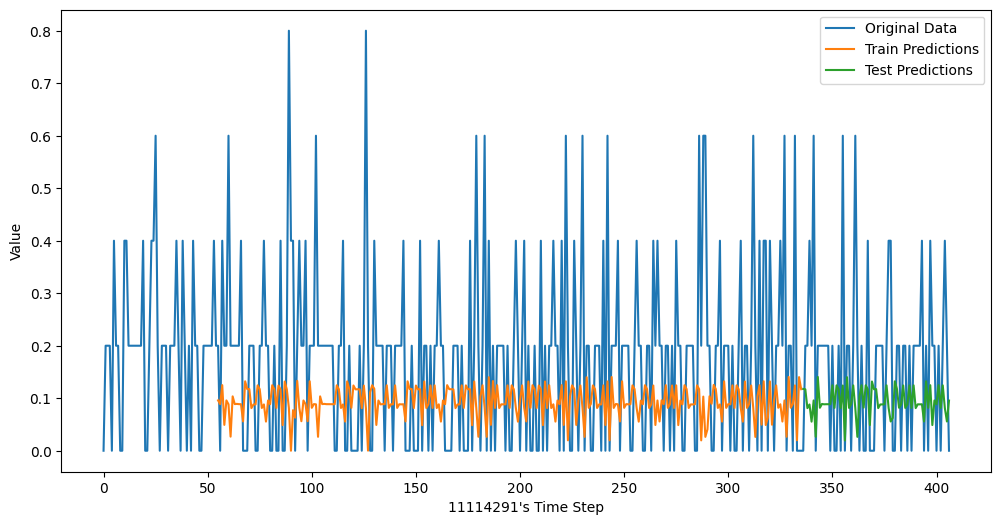

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.69132492]]), 'last_predict_or': array([[0.13826498]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.0955]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 11114291, 'scaler_min': np.float32(0.13896355), 'scaler_max': np.float32(0.14036874), 'scaler_mux': 100.0, 'scaler_div': np.int64(5)} now 2025-06-27 17:14:05.726189


In [115]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 11114291
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:14:11.793437
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.11916701 0.1193084 0.00014138967
scaler_min, scaler_max, scaler_mux, scaler_div 0.11916701 0.1193084 1000.0 5


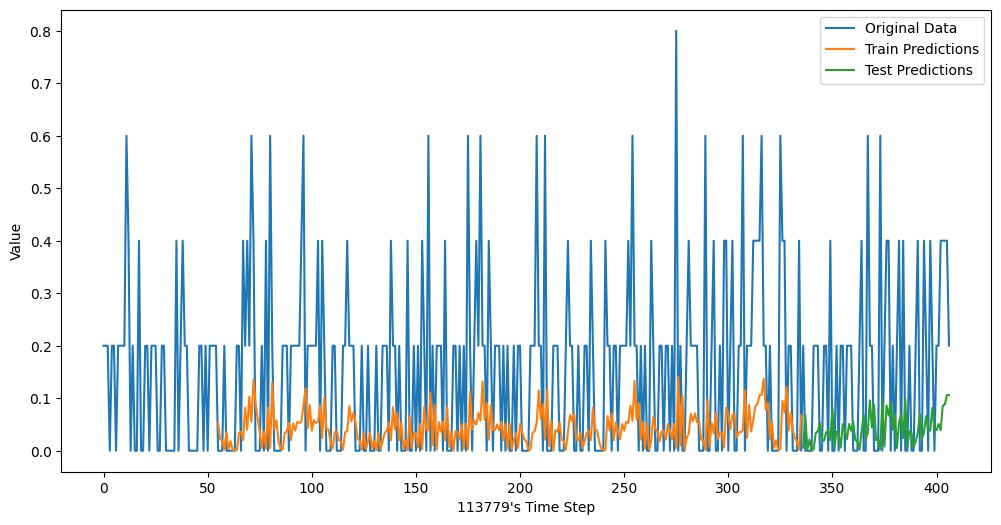

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.69714054]]), 'last_predict_or': array([[0.13942811]], dtype=float32), 'restored_last_predict': array([[20.261002]], dtype=float32), 'test_last_predict': array([[0.106]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 113779, 'scaler_min': np.float32(0.11916701), 'scaler_max': np.float32(0.1193084), 'scaler_mux': 1000.0, 'scaler_div': np.int64(5)} now 2025-06-27 17:16:52.284071


In [116]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 113779
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:17:09.706164
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.11803952 0.11910239 0.00106287
scaler_min, scaler_max, scaler_mux, scaler_div 0.11803952 0.11910239 100.0 6


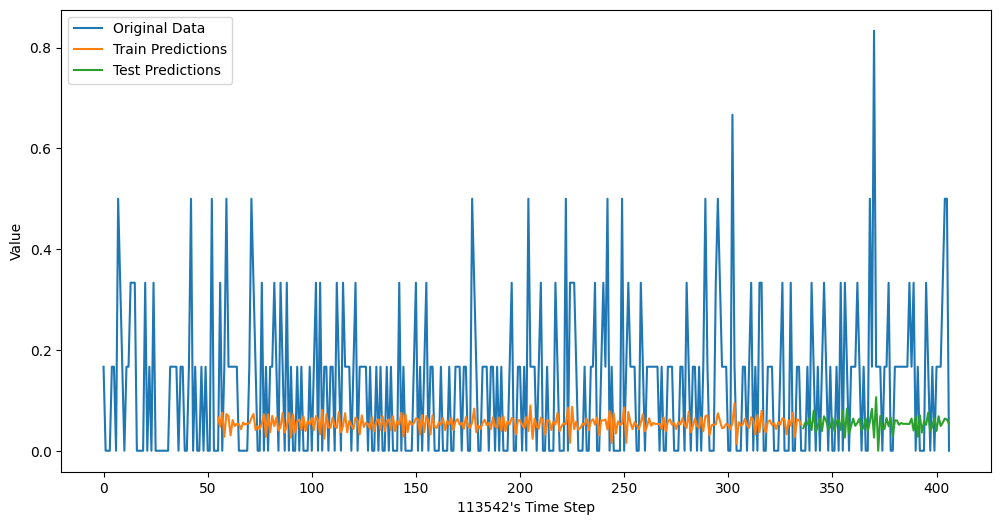

{'scaled_data_max': np.float64(4.999999998), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.23289652]]), 'last_predict_or': array([[0.03881609]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.0533]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 113542, 'scaler_min': np.float32(0.11803952), 'scaler_max': np.float32(0.11910239), 'scaler_mux': 100.0, 'scaler_div': np.int64(6)} now 2025-06-27 17:19:51.612728


In [117]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 113542
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:20:37.753409
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.16517374 0.16520332 2.9578805e-05
scaler_min, scaler_max, scaler_mux, scaler_div 0.16517374 0.16520332 10000.0 5


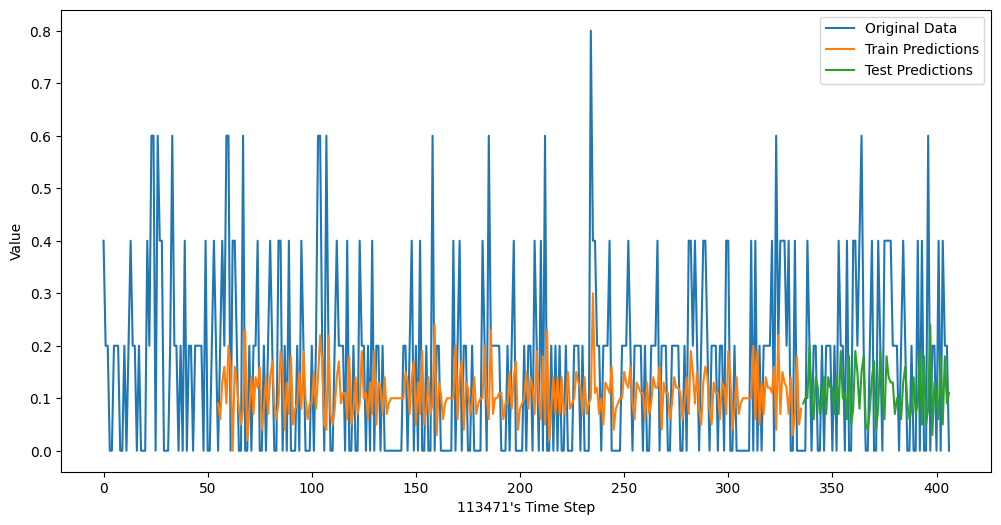

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.66399544]]), 'last_predict_or': array([[0.13279909]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.11]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 113471, 'scaler_min': np.float32(0.16517374), 'scaler_max': np.float32(0.16520332), 'scaler_mux': 10000.0, 'scaler_div': np.int64(5)} now 2025-06-27 17:23:21.013622


In [118]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 113471
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:24:09.916309
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.13614866 0.19367433 0.057525665
scaler_min, scaler_max, scaler_mux, scaler_div 0.13614866 0.19367433 10.0 5


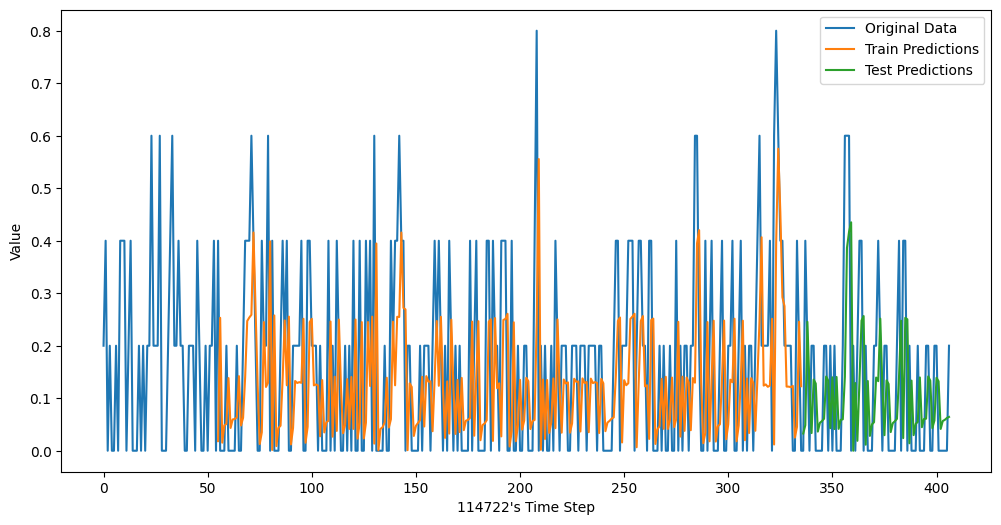

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.47617815]]), 'last_predict_or': array([[0.09523563]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.06437]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 114722, 'scaler_min': np.float32(0.13614866), 'scaler_max': np.float32(0.19367433), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 17:26:53.577521


In [119]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114722
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:27:22.394777
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.19061822 0.19150972 0.0008915067
scaler_min, scaler_max, scaler_mux, scaler_div 0.19061822 0.19150972 1000.0 5


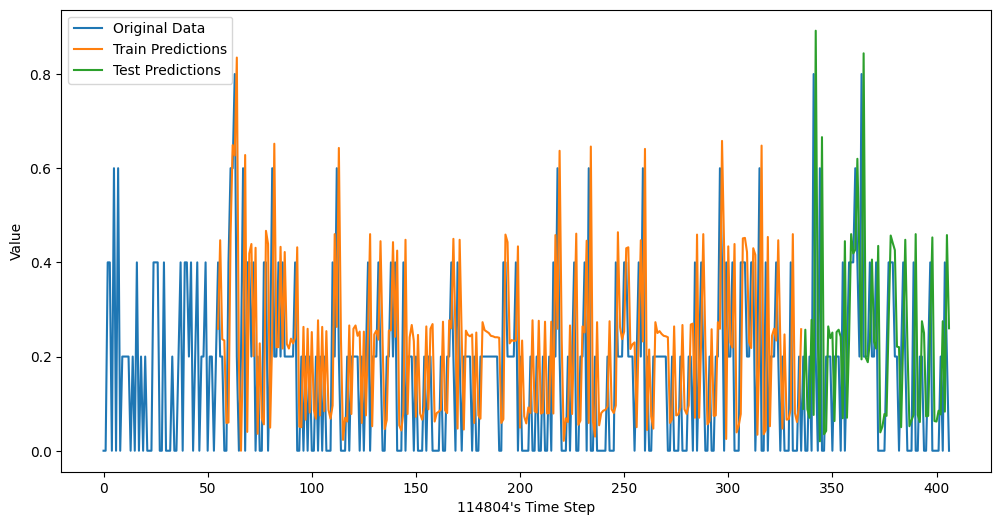

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.04493298]]), 'last_predict_or': array([[0.2089866]], dtype=float32), 'restored_last_predict': array([[18.368]], dtype=float32), 'test_last_predict': array([[0.26]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 114804, 'scaler_min': np.float32(0.19061822), 'scaler_max': np.float32(0.19150972), 'scaler_mux': 1000.0, 'scaler_div': np.int64(5)} now 2025-06-27 17:30:06.002434


In [120]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114804
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:30:41.087476
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.16490954 0.16837588 0.003466338
scaler_min, scaler_max, scaler_mux, scaler_div 0.16490954 0.16837588 100.0 5


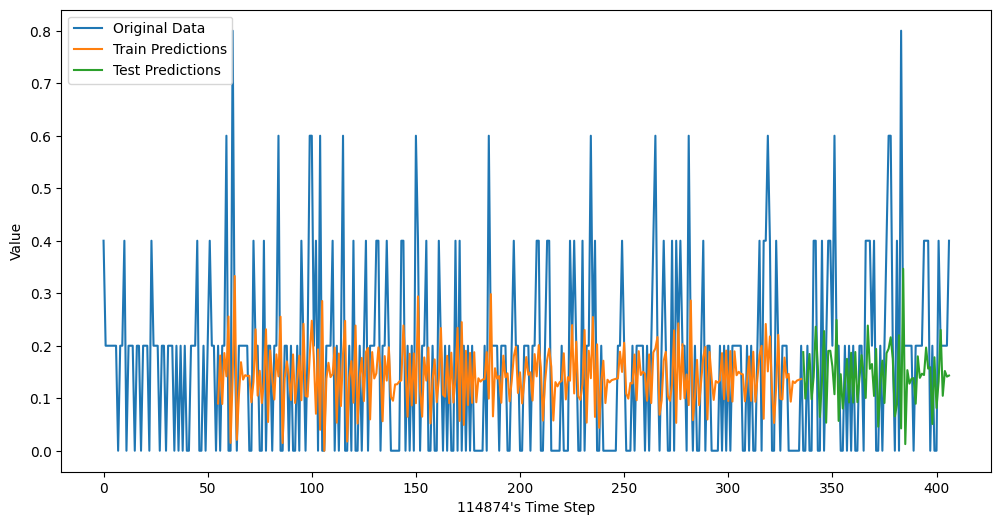

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[-0.40819444]]), 'last_predict_or': array([[-0.08163889]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.1432]], dtype=float32), 'X_last': array([[[0.4]]]), 'random_state': 114874, 'scaler_min': np.float32(0.16490954), 'scaler_max': np.float32(0.16837588), 'scaler_mux': 100.0, 'scaler_div': np.int64(5)} now 2025-06-27 17:33:32.905671


In [121]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114874
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:34:50.836081
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.14174809 0.14229886 0.0005507767
scaler_min, scaler_max, scaler_mux, scaler_div 0.14174809 0.14229886 1000.0 5


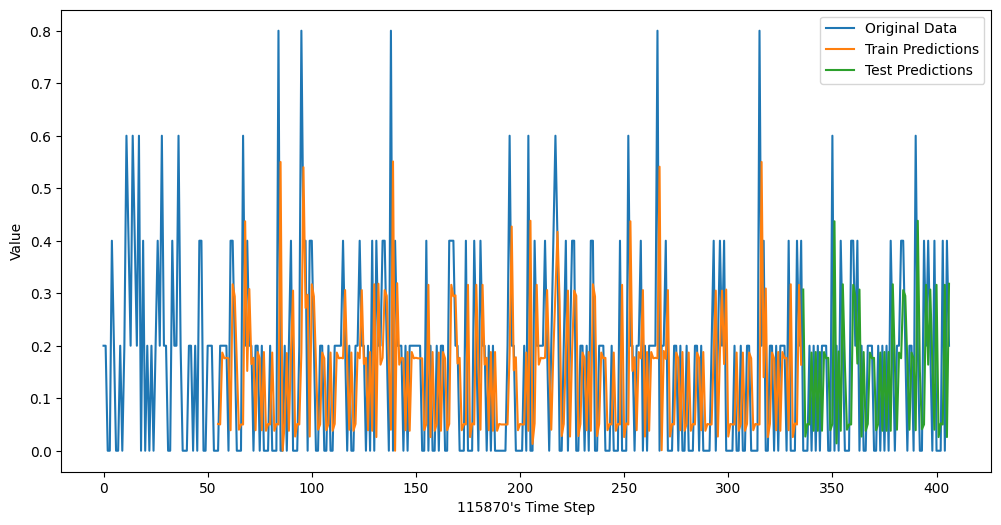

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.86956114]]), 'last_predict_or': array([[0.17391223]], dtype=float32), 'restored_last_predict': array([[32.164]], dtype=float32), 'test_last_predict': array([[0.31800002]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 115870, 'scaler_min': np.float32(0.14174809), 'scaler_max': np.float32(0.14229886), 'scaler_mux': 1000.0, 'scaler_div': np.int64(5)} now 2025-06-27 17:37:36.844384


In [122]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 115870
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:37:57.791805
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.11699307 0.117458776 0.000465706
scaler_min, scaler_max, scaler_mux, scaler_div 0.11699307 0.117458776 1000.0 5


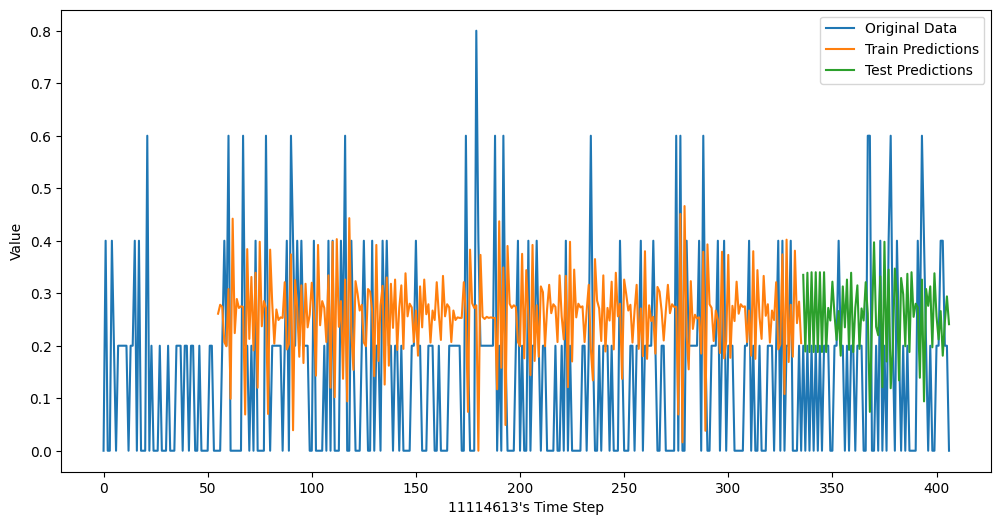

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.97292058]]), 'last_predict_or': array([[0.19458412]], dtype=float32), 'restored_last_predict': array([[77.591]], dtype=float32), 'test_last_predict': array([[0.241]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 11114613, 'scaler_min': np.float32(0.11699307), 'scaler_max': np.float32(0.117458776), 'scaler_mux': 1000.0, 'scaler_div': np.int64(5)} now 2025-06-27 17:40:40.048943


In [123]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 11114613
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 17:42:10.093118
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.17392613 0.18153773 0.0076116025
scaler_min, scaler_max, scaler_mux, scaler_div 0.17392613 0.18153773 100.0 5


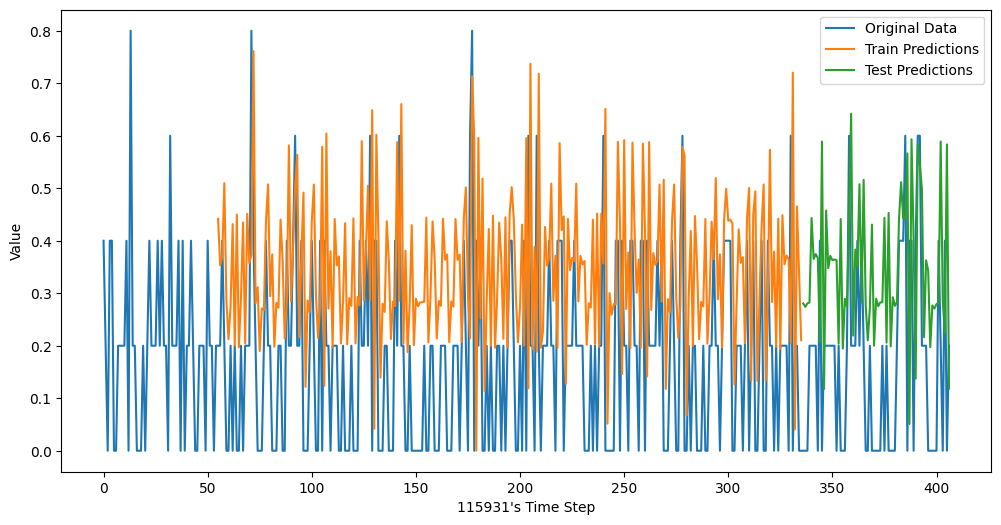

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.73703194]]), 'last_predict_or': array([[0.3474064]], dtype=float32), 'restored_last_predict': array([[17.348]], dtype=float32), 'test_last_predict': array([[0.11849999]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 115931, 'scaler_min': np.float32(0.17392613), 'scaler_max': np.float32(0.18153773), 'scaler_mux': 100.0, 'scaler_div': np.int64(5)} now 2025-06-27 17:44:54.914932


In [124]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 115931
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:03:10.214936
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.16692372 0.16721235 0.0002886355
scaler_min, scaler_max, scaler_mux, scaler_div 0.16692372 0.16721235 1000.0 5


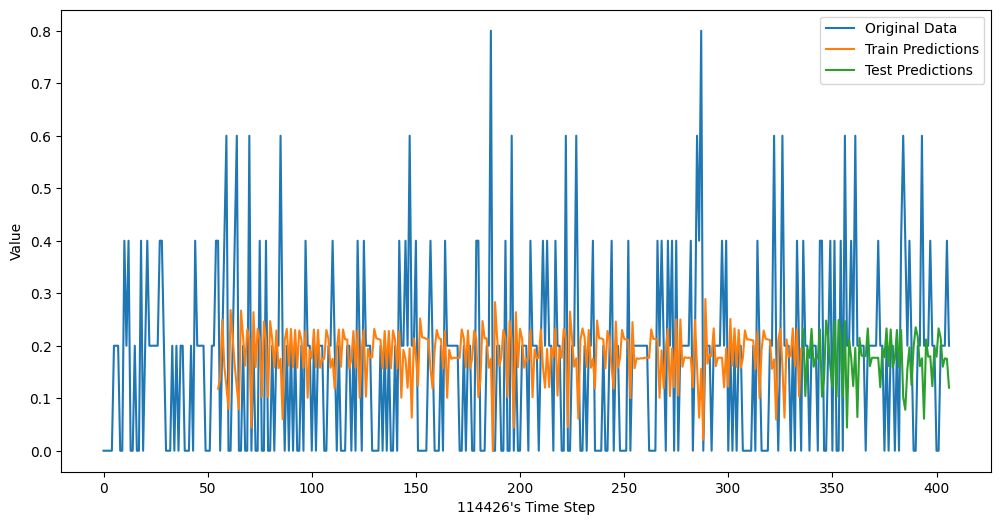

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[-0.22159429]]), 'last_predict_or': array([[-0.04431886]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.12]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 114426, 'scaler_min': np.float32(0.16692372), 'scaler_max': np.float32(0.16721235), 'scaler_mux': 1000.0, 'scaler_div': np.int64(5)} now 2025-06-27 18:05:41.435837


In [130]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114426
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 10
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:00:31.079214
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.20832147 0.20886059 0.000539124
scaler_min, scaler_max, scaler_mux, scaler_div 0.20832147 0.20886059 1000.0 4


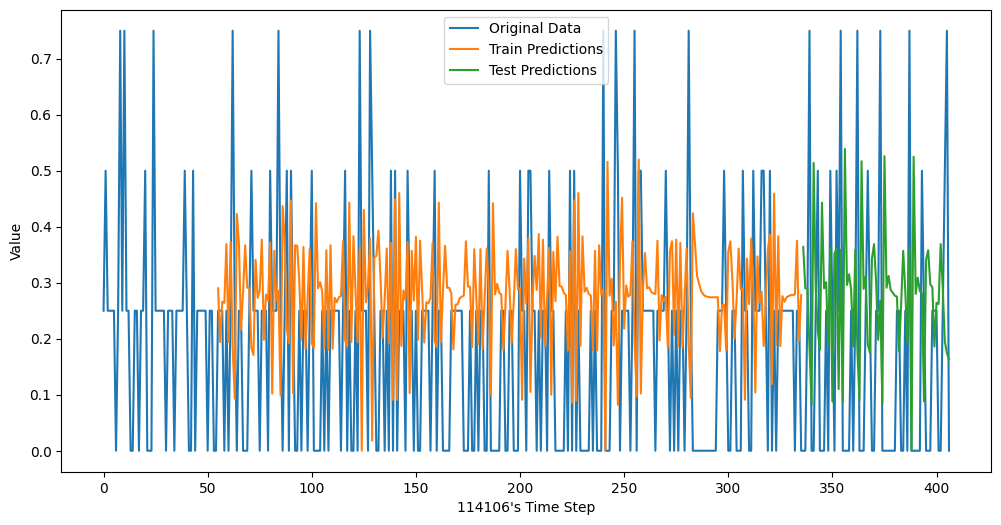

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.07168324]]), 'last_predict_or': array([[0.01792081]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.163]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 114106, 'scaler_min': np.float32(0.20832147), 'scaler_max': np.float32(0.20886059), 'scaler_mux': 1000.0, 'scaler_div': np.int64(4)} now 2025-06-27 18:03:10.209060


In [129]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114106
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:05:48.784758
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.1273877 0.12743562 4.7922134e-05
scaler_min, scaler_max, scaler_mux, scaler_div 0.1273877 0.12743562 10000.0 5


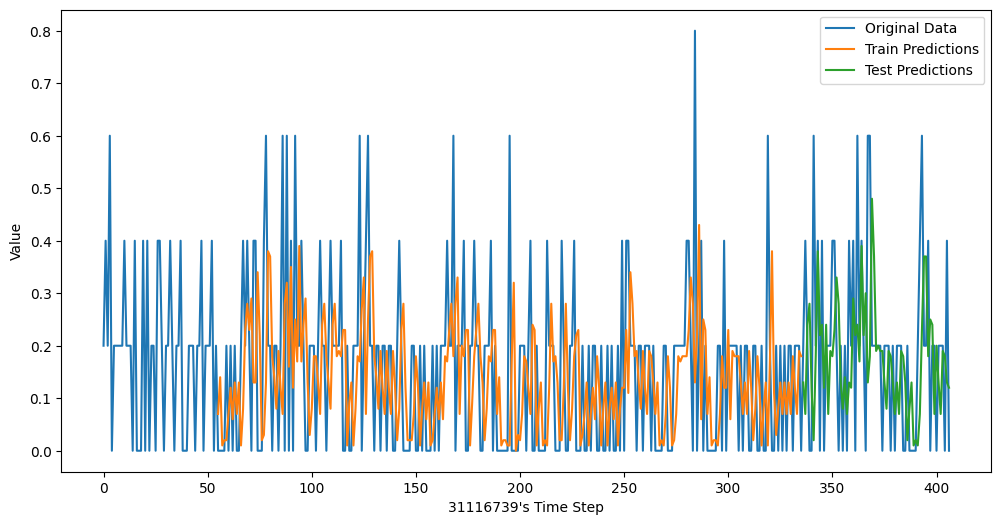

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.00224629]]), 'last_predict_or': array([[0.20044926]], dtype=float32), 'restored_last_predict': array([[730.62006]], dtype=float32), 'test_last_predict': array([[0.12]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 31116739, 'scaler_min': np.float32(0.1273877), 'scaler_max': np.float32(0.12743562), 'scaler_mux': 10000.0, 'scaler_div': np.int64(5)} now 2025-06-27 18:08:28.140968


In [131]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 31116739
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:08:54.195421
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.20808753 0.20811976 3.223121e-05
scaler_min, scaler_max, scaler_mux, scaler_div 0.20808753 0.20811976 10000.0 4


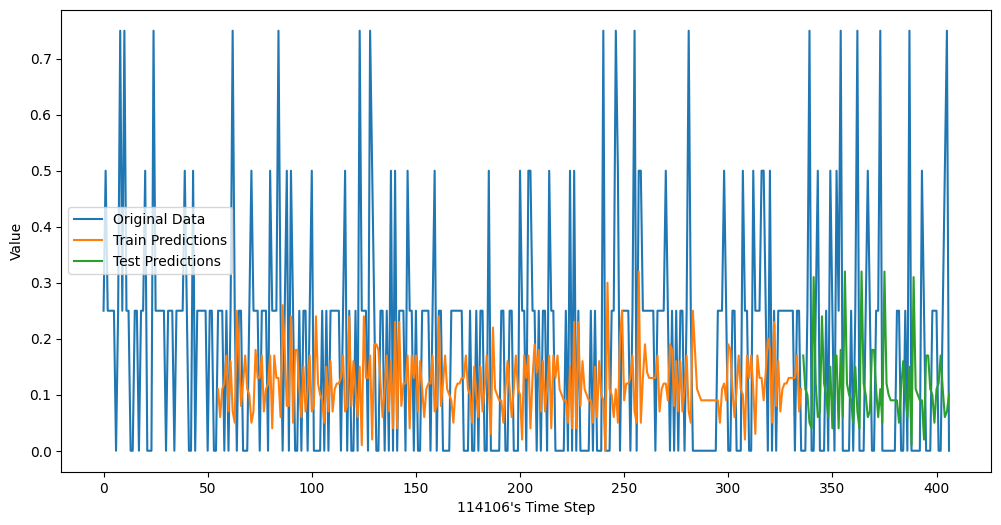

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.98972541]]), 'last_predict_or': array([[0.24743135]], dtype=float32), 'restored_last_predict': array([[393.44]], dtype=float32), 'test_last_predict': array([[0.09999999]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 114106, 'scaler_min': np.float32(0.20808753), 'scaler_max': np.float32(0.20811976), 'scaler_mux': 10000.0, 'scaler_div': np.int64(4)} now 2025-06-27 18:11:31.704577


In [132]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114106
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:13:26.125656
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.21863116 0.21907769 0.0004465282
scaler_min, scaler_max, scaler_mux, scaler_div 0.21863116 0.21907769 1000.0 4


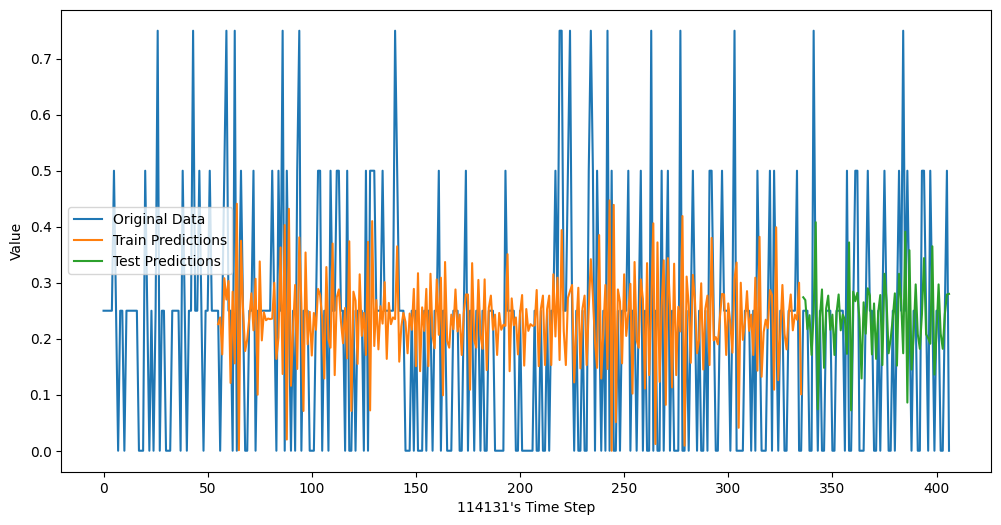

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[-0.42062095]]), 'last_predict_or': array([[-0.10515524]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.28]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 114131, 'scaler_min': np.float32(0.21863116), 'scaler_max': np.float32(0.21907769), 'scaler_mux': 1000.0, 'scaler_div': np.int64(4)} now 2025-06-27 18:16:02.200645


In [133]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 114131
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:16:39.329589
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.117738724 0.14286608 0.025127351
scaler_min, scaler_max, scaler_mux, scaler_div 0.117738724 0.14286608 10.0 5


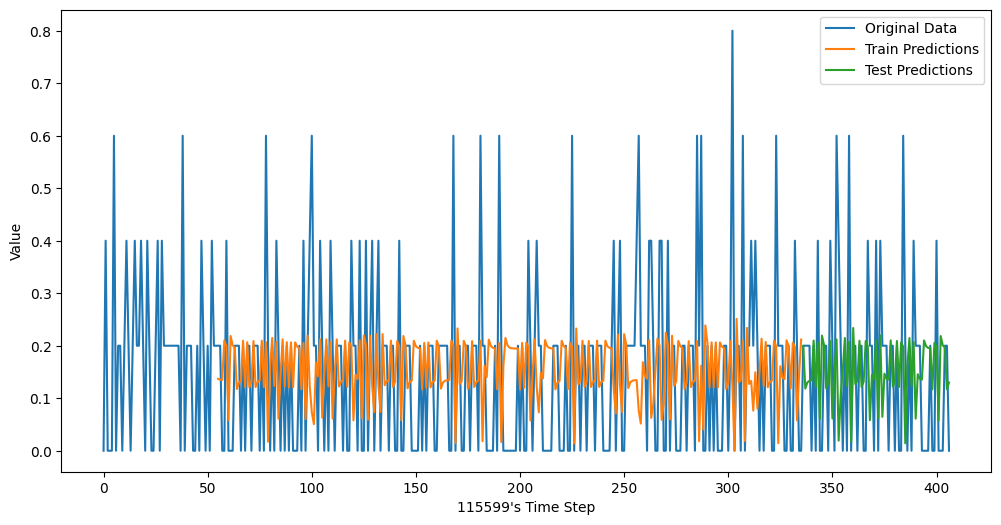

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.60989838]]), 'last_predict_or': array([[0.12197968]], dtype=float32), 'restored_last_predict': array([[0.04241]], dtype=float32), 'test_last_predict': array([[0.12981999]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 115599, 'scaler_min': np.float32(0.117738724), 'scaler_max': np.float32(0.14286608), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 18:19:18.064222


In [134]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 115599
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:19:24.535088
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.06498605 0.16633114 0.10134509
scaler_min, scaler_max, scaler_mux, scaler_div 0.06498605 0.16633114 1.0 5


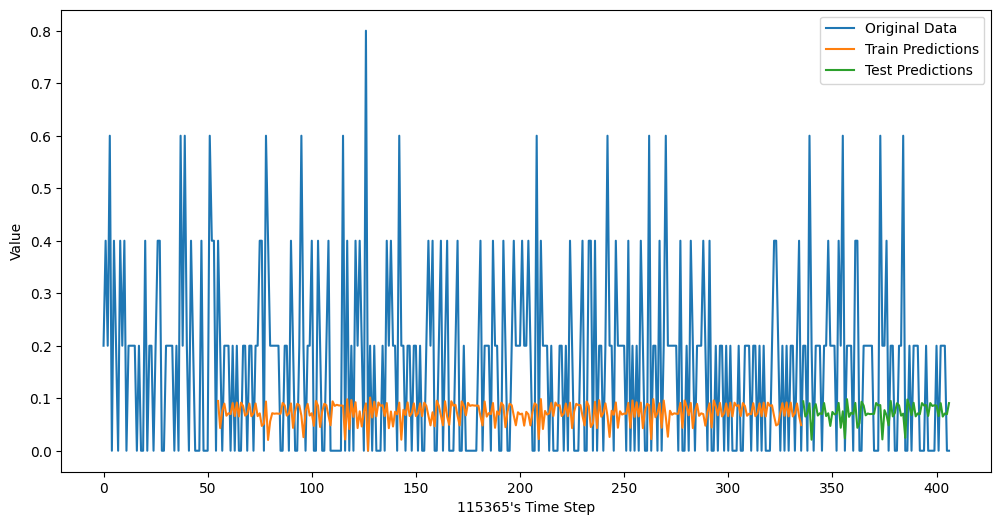

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.90241665]]), 'last_predict_or': array([[0.38048333]], dtype=float32), 'restored_last_predict': array([[0.315497]], dtype=float32), 'test_last_predict': array([[0.090683]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 115365, 'scaler_min': np.float32(0.06498605), 'scaler_max': np.float32(0.16633114), 'scaler_mux': 1.0, 'scaler_div': np.int64(5)} now 2025-06-27 18:21:56.101924


In [135]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 115365
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:24:02.110784
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.15102825 0.151142 0.000113755465
scaler_min, scaler_max, scaler_mux, scaler_div 0.15102825 0.151142 1000.0 5


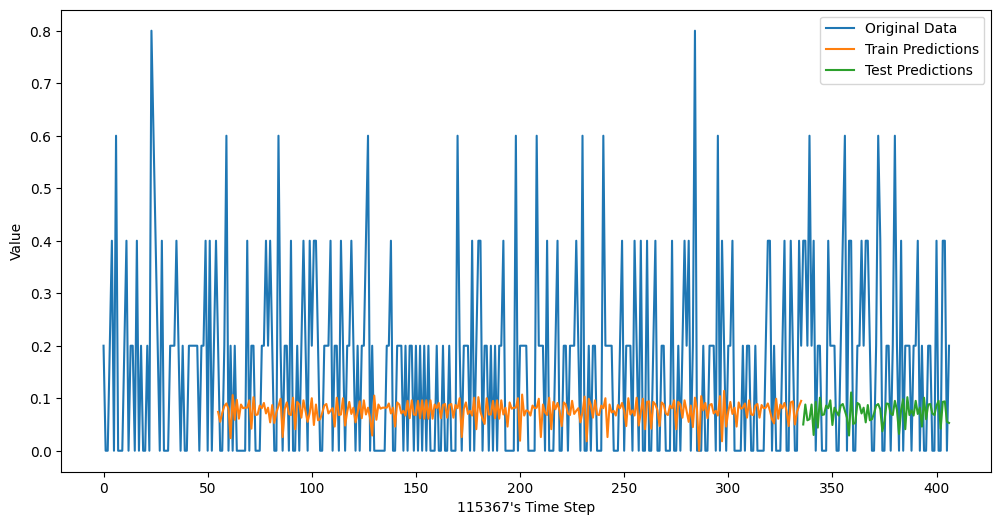

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.06309138]]), 'last_predict_or': array([[0.21261828]], dtype=float32), 'restored_last_predict': array([[61.59]], dtype=float32), 'test_last_predict': array([[0.053]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 115367, 'scaler_min': np.float32(0.15102825), 'scaler_max': np.float32(0.151142), 'scaler_mux': 1000.0, 'scaler_div': np.int64(5)} now 2025-06-27 18:26:42.838651


In [136]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 115367
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:26:53.821779
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.17419602 0.1881195 0.013923481
scaler_min, scaler_max, scaler_mux, scaler_div 0.17419602 0.1881195 10.0 4


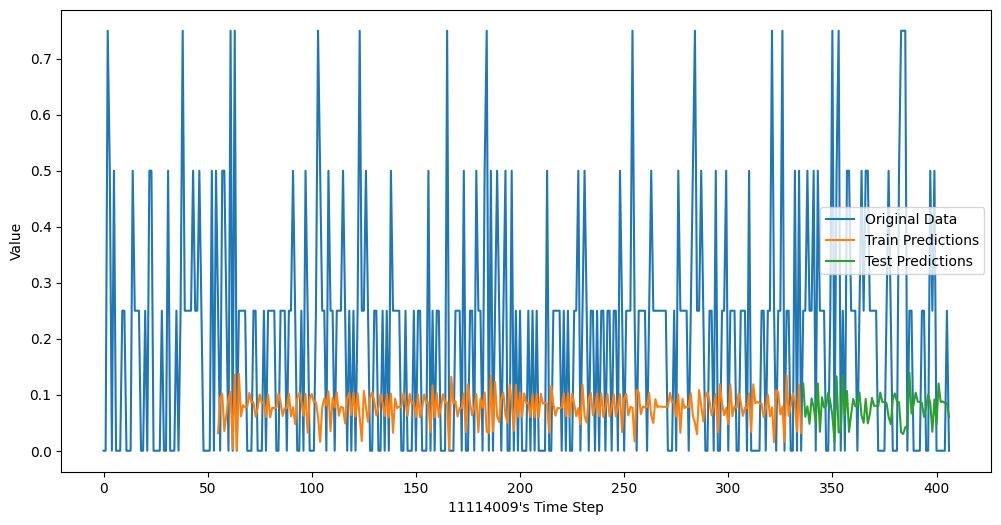

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.13842916]]), 'last_predict_or': array([[0.2846073]], dtype=float32), 'restored_last_predict': array([[1.10411]], dtype=float32), 'test_last_predict': array([[0.06006]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 11114009, 'scaler_min': np.float32(0.17419602), 'scaler_max': np.float32(0.1881195), 'scaler_mux': 10.0, 'scaler_div': np.int64(4)} now 2025-06-27 18:29:33.318842


In [137]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 11114009
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:41:03.422430
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.13753492 0.17349795 0.03596303
scaler_min, scaler_max, scaler_mux, scaler_div 0.13753492 0.17349795 10.0 5


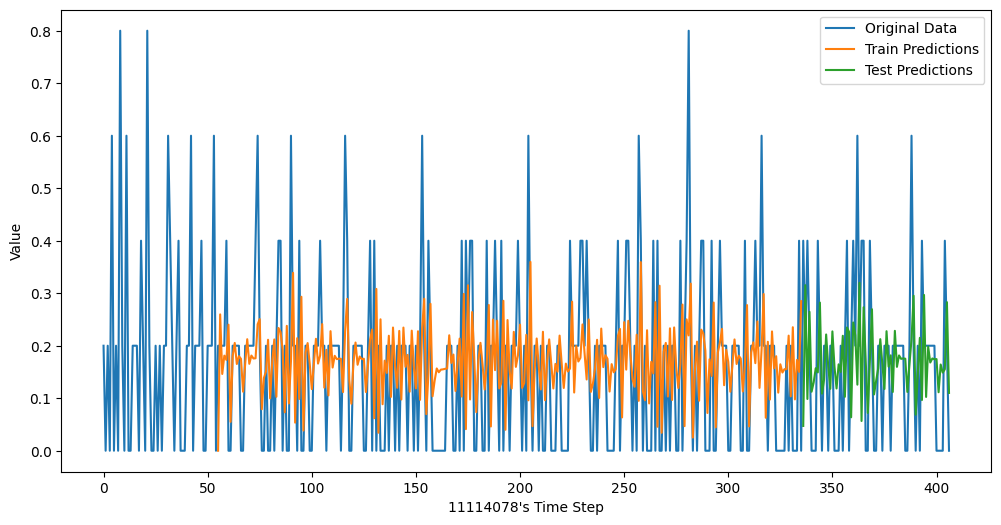

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[-0.37108757]]), 'last_predict_or': array([[-0.07421751]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.11009999]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 11114078, 'scaler_min': np.float32(0.13753492), 'scaler_max': np.float32(0.17349795), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 18:43:39.425876


In [141]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 11114078
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

In [138]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 31116862
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:30:32.535375
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.13773812 0.22850548 0.090767354
scaler_min, scaler_max, scaler_mux, scaler_div 0.13773812 0.22850548 10.0 5


{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.2482269]]), 'last_predict_or': array([[0.04964538]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.51801]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 31116862, 'scaler_min': np.float32(0.13773812), 'scaler_max': np.float32(0.22850548), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 18:33:07.764012


cur_time 2025-06-27 18:34:11.406871
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.18007311 0.18013477 6.1661005e-05
scaler_min, scaler_max, scaler_mux, scaler_div 0.18007311 0.18013477 10000.0 5


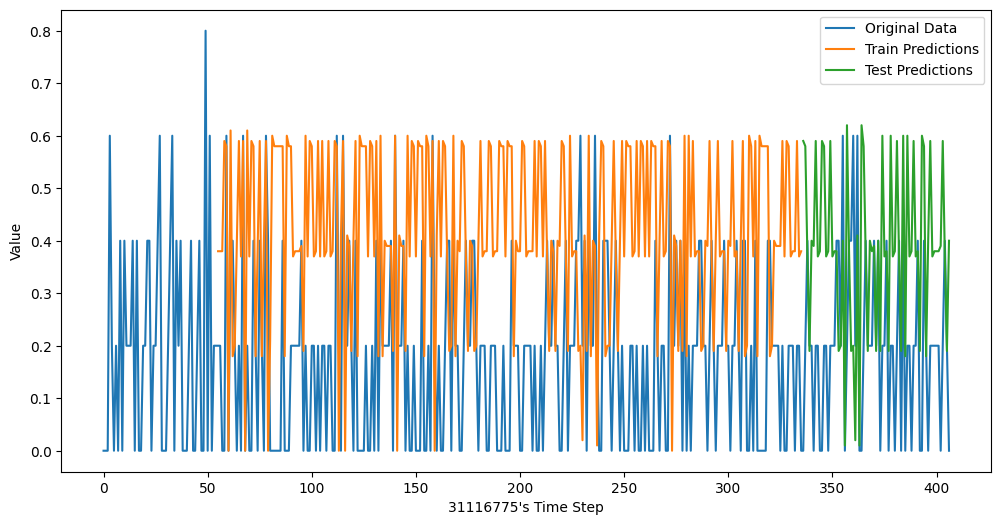

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.05173029]]), 'last_predict_or': array([[0.21034606]], dtype=float32), 'restored_last_predict': array([[302.73]], dtype=float32), 'test_last_predict': array([[0.39999998]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 31116775, 'scaler_min': np.float32(0.18007311), 'scaler_max': np.float32(0.18013477), 'scaler_mux': 10000.0, 'scaler_div': np.int64(5)} now 2025-06-27 18:36:44.603220


In [139]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 31116775
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:37:06.725952
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.18292768 0.18293744 9.760261e-06
scaler_min, scaler_max, scaler_mux, scaler_div 0.18292768 0.18293744 100000.0 4


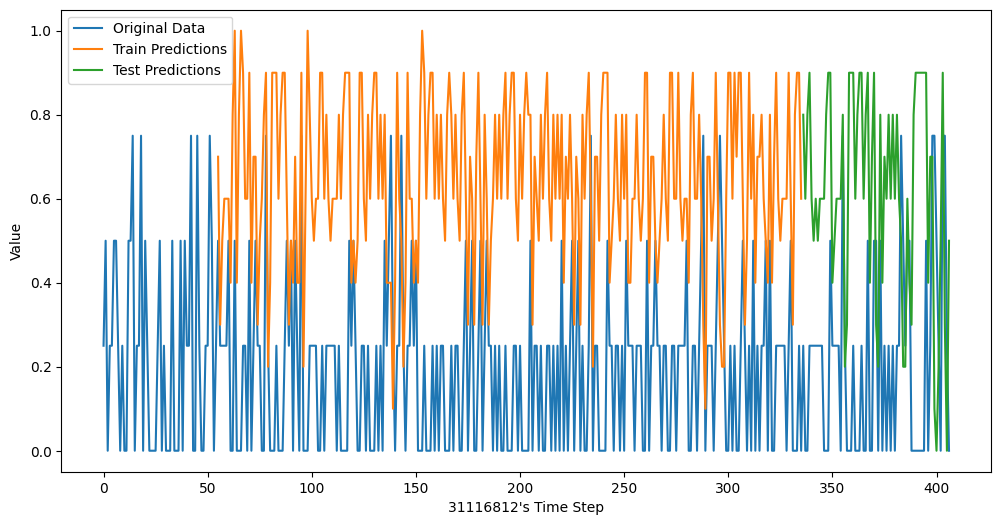

{'scaled_data_max': np.float64(3.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[-0.16170478]]), 'last_predict_or': array([[-0.04042619]], dtype=float32), 'restored_last_predict': array([[0.]]), 'test_last_predict': array([[0.5]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 31116812, 'scaler_min': np.float32(0.18292768), 'scaler_max': np.float32(0.18293744), 'scaler_mux': 100000.0, 'scaler_div': np.int64(4)} now 2025-06-27 18:39:42.590819


In [140]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 31116812
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

In [142]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 11114154
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

cur_time 2025-06-27 18:46:00.108043
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.08585542 0.18592083 0.10006542
scaler_min, scaler_max, scaler_mux, scaler_div 0.08585542 0.18592083 1.0 5


{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[1.33634135]]), 'last_predict_or': array([[0.26726827]], dtype=float32), 'restored_last_predict': array([[0.181413]], dtype=float32), 'test_last_predict': array([[0.046052]], dtype=float32), 'X_last': array([[[0.2]]]), 'random_state': 11114154, 'scaler_min': np.float32(0.08585542), 'scaler_max': np.float32(0.18592083), 'scaler_mux': 1.0, 'scaler_div': np.int64(5)} now 2025-06-27 18:48:33.598143


cur_time 2025-06-27 18:56:41.385708
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
lens  =  281 71 1
types =  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
min, max, diff 0.15739636 0.18398778 0.02659142
scaler_min, scaler_max, scaler_mux, scaler_div 0.15739636 0.18398778 10.0 5


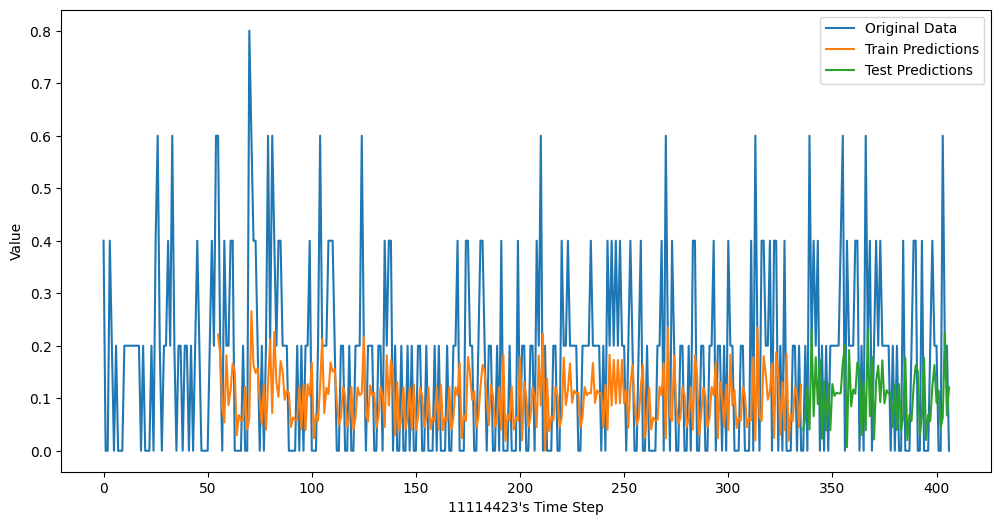

{'scaled_data_max': np.float64(4.0), 'scaled_data_min': np.float64(0.0), 'last_predict': array([[0.94381429]]), 'last_predict_or': array([[0.18876286]], dtype=float32), 'restored_last_predict': array([[0.31366003]], dtype=float32), 'test_last_predict': array([[0.1207]], dtype=float32), 'X_last': array([[[0.]]]), 'random_state': 11114423, 'scaler_min': np.float32(0.15739636), 'scaler_max': np.float32(0.18398778), 'scaler_mux': 10.0, 'scaler_div': np.int64(5)} now 2025-06-27 18:59:11.379780


In [143]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 11114423
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

In [ ]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

In [ ]:
### Good Condition #1
t_version = 'T_01_14'
db_file_path = '../db/metrics.db'
random_state = 
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 55
print('cur_time', datetime.now())
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

In [8]:
"""
version TEXT, random_state INTEGER, possibility FLOAT, max INTEGER
"""
def insert_possi(version, max, possi, random_state):
    table_name='rndforest_possi'
    db_file_path='../db/metrics.db'
    sql = f'insert into {table_name} (version, random_state, possibility, max) values(\\"{version}\\", {random_state}, {possi}, {max});'
    !echo "{sql}" | sqlite3 {db_file_path}

print(f'Current Step : [now {datetime.now()}]')

Current Step : [now 2025-06-20 22:43:02.880812]


In [26]:
def get_possibility(random_states, db_file_path, layer_count, activation, units, scaler_type, sequence_length=10):
    random_state_begin = 3700
    # predict_scale = 10000000
    predict_scale = 1000000
    predict_round = 7
    results = []
    for random_state in tqdm(random_states):
        scaled_data_max, last_predict, random_state = analyze_v1(random_state=random_state,
                                                                 version=version,
                                                                 predict_round=predict_round,
                                                                 db_file_path=db_file_path,
                                                                 scaler_type=scaler_type,
                                                                 layer_count=layer_count,
                                                                 activation=activation,
                                                                 units=units,
                                                                 draw_graph=False,
                                                                 sequence_length=sequence_length,
                                                                 verbose=0)
        results.append((scaled_data_max, last_predict, random_state))
        if last_predict > 1.7:
            print(scaled_data_max, last_predict, random_state)
    return results

In [28]:
for result in results:
    print(result)

(np.float64(3.0), array([[0.51065975]]), 3731)
(np.float64(4.0), array([[0.03436218]]), 3786)
(np.float64(4.999999998), array([[0.98191944]]), 3702)
(np.float64(3.0), array([[1.15016282]]), 3715)
(np.float64(3.0), array([[1.67712224]]), 3734)
(np.float64(4.0), array([[-0.16663458]]), 3753)
(np.float64(4.0), array([[0.22691065]]), 3761)
(np.float64(3.0), array([[1.05514777]]), 3770)


In [19]:
for result in results:
    print(result)
    insert_possi(version=version, max=result[0], possi=result[1][0][0], random_state=result[2])

(np.float64(3.0), array([[0.65072489]]), 3731)
(np.float64(4.0), array([[0.50776754]]), 3786)
(np.float64(4.999999998), array([[0.55112202]]), 3702)
(np.float64(3.0), array([[0.77709711]]), 3715)
(np.float64(3.0), array([[1.09201658]]), 3734)
(np.float64(4.0), array([[1.04803503]]), 3753)
(np.float64(4.0), array([[0.75670734]]), 3761)
(np.float64(3.0), array([[0.96134448]]), 3770)


In [ ]:

actual_numbers = [
    [1175, 3, 4, 6, 8, 32, 42],
    [1174, 8, 11, 14, 17, 36, 39],
    [1173, 1, 5, 18, 20, 30, 35],
    [1172, 7, 9, 24, 40, 42, 44],
    [1171, 3, 6, 7, 11, 12, 17],
    [1170, 3, 13, 28, 34, 38, 42],
    [1169, 5, 12, 24, 26, 39, 42],
    [1168, 9, 21, 24, 30, 33, 37],
    [1167, 8, 23, 31, 35, 39, 40],
]